# 온실가스 상관분석
### by ChonnyJ

##### 사용할 라이브러리 import

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import tensorflow
from netCDF4 import Dataset
import os, sys, glob
from sklearn import linear_model
import statsmodels.api as sm
%matplotlib inline
from matplotlib import pyplot as plt

## 데이터 전처리

#### (1) OHC GHG POP GDP 파일 로딩

In [2]:
os.system('clear')
ddir = os.getcwd() + '/dataset/'
fin1 = 'ohc700.nc'
ds = Dataset(ddir + fin1, 'r')
ds.set_auto_mask(False)
heatcon = ds['yearl_h22_WO'][:]
yearly_heat_content = {}
yearly_heat_content['year'] = [i for i in range(1955, 2022)]
yearly_heat_content['OHC_700'] = heatcon
ds.close()

ohc_data = pd.DataFrame(yearly_heat_content)
ghg_data = pd.read_csv(ddir+ 'ghg.csv')
pop_data = pd.read_csv(ddir+ 'pop.csv')
gdp_data = pd.read_csv(ddir+ 'gdp.csv')

#Renaming
ghg_data = ghg_data.drop("region_ar6_10", axis=1)
pop_data.rename(columns = {"Population (historical estimates and future projections)": "population"}, inplace = True)
pop_data.rename(columns = {"Entity": "country", "Code": "ISO", "Year": "year"}, inplace =True)
gdp_data.rename(columns = {"Country Code": "ISO"}, inplace = True)

##### 해양열량(OHC) 데이터 형태

In [3]:
ohc_data

,year,OHC_700
0,1955,-3.201000
1,1956,-2.608000
2,1957,-4.613000
3,1958,-1.533000
4,1959,-2.189000
...,...,...
62,2017,15.878000
63,2018,16.722000
64,2019,17.726000
65,2020,17.524000


##### 해양열량 그래프

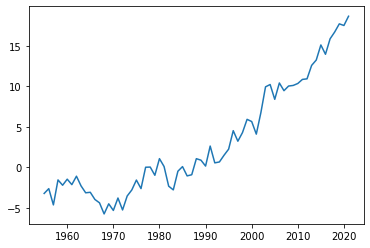

In [4]:
plt.plot(ohc_data['year'],ohc_data['OHC_700']);
plt.show()

##### 온실가스  데이터 형태

온실가스 데이터 설명
- 인덱스가 년도가 아닌 시계열 데이터이다. 
- 같은 연도인 레코드가 여러개가 있으며 심지어 나라별로도 연도가 중복된다.
- 탄소, 메탄, 질소, 프레온가스 각각의 온실가스 데이터에 GWP100 수치를 곱하여 모두 더하면 총합 GHG가 나온다.

** GWP100 - 배출된 가스의 100년동안의 영향력(가중치)을 수치화한 것 

In [5]:
ghg_data

,ISO,country,region_ar6_dev,year,subsector_title,CO2,CH4,N2O,Fgas,GHG
0,ABW,Aruba,developing,1970,Residential,5.452099e+02,4.345413,1.310954,0.0,5.508663e+02
1,ABW,Aruba,developing,1970,Electricity & heat,3.091397e+04,11.220446,36.717278,0.0,3.096191e+04
2,ABW,Aruba,developing,1970,Oil and gas fugitive emissions,6.324320e-03,1142.233938,0.000000,0.0,1.142240e+03
3,ABW,Aruba,developing,1970,Other (energy systems),3.173774e+04,133.755885,312.137205,0.0,3.218363e+04
4,ABW,Aruba,developing,1970,Chemicals,1.455350e+03,0.000000,0.177366,0.0,1.455528e+03
...,...,...,...,...,...,...,...,...,...,...
196634,ZWE,Zimbabwe,developing,2020,Metals,7.720092e+05,0.000000,0.000000,0.0,7.720092e+05
196635,ZWE,Zimbabwe,developing,2020,Other (industry),9.523549e+05,0.000000,0.000000,0.0,9.523549e+05
196636,ZWE,Zimbabwe,developing,2020,Other (transport),3.099450e+05,0.000000,0.000000,0.0,3.099450e+05
196637,ZWE,Zimbabwe,developing,2020,Rail,1.491236e+05,0.000000,0.000000,0.0,1.491236e+05


##### 인구 데이터

- 1950년 부터 2020년 까지의 데이터는 UN 실측 데이터이다.
- 2020 ~ 2100년 까지의 인구 데이터는 UN의 인구 시나리오에 의존한 예측데이터이다.
- 그 이전의 데이터는 활용 하지 않을 예정

In [6]:
pop_data

,country,ISO,year,population
0,Afghanistan,AFG,-10000,14737
1,Afghanistan,AFG,-9000,20405
2,Afghanistan,AFG,-8000,28253
3,Afghanistan,AFG,-7000,39120
4,Afghanistan,AFG,-6000,54166
...,...,...,...,...
74769,Zimbabwe,ZWE,2096,30940779
74770,Zimbabwe,ZWE,2097,30952208
74771,Zimbabwe,ZWE,2098,30959811
74772,Zimbabwe,ZWE,2099,30964052


##### GDP 데이터

- 결측치가 매우 많음: 선형회귀로 결측치를 메운다.

###### GDP 데이터 형식 변경
-연도 인덱스화

In [7]:
year_index = []
for i in range(0, 266):
    for year in range(14, 65):
        year_index.append([year+1956, gdp_data.iloc[i][1],  gdp_data.loc[i][year]])
year_index = pd.DataFrame(year_index)
year_index.columns = ['year', 'ISO', 'GDP']
gdp_data = year_index
gdp_data

,year,ISO,GDP
0,1970,ABW,NaN
1,1971,ABW,NaN
2,1972,ABW,NaN
3,1973,ABW,NaN
4,1974,ABW,NaN
...,...,...,...
13561,2016,ZWE,2.054868e+10
13562,2017,ZWE,1.758490e+10
13563,2018,ZWE,1.811550e+10
13564,2019,ZWE,1.928430e+10


###### gdp 결측 선형회귀

In [8]:
gdp_list = gdp_data.ISO.unique()
temp = pd.DataFrame(columns=["year", "ISO", "GDP"])

for elem in gdp_list:
    dddd = gdp_data.loc[gdp_data.ISO==elem]
    if dddd.isnull().values.any():
        if dddd.GDP.isnull().values.all():
            temp = pd.concat([temp, dddd], ignore_index = True, axis=0)
            continue
        X = dddd.year
        X = sm.add_constant(X)
        Y = dddd.GDP

        linearmodel = sm.OLS(Y, X, missing='drop')
        result = linearmodel.fit()
        pred = result.predict(X)
        pred = pd.DataFrame(pred, columns=["GDP"], index=dddd.index)
        temp = pd.concat([temp, pd.concat([dddd.year,dddd.ISO, pred],axis=1)], axis=0)
    else:
        temp = pd.concat([temp, dddd], ignore_index = True, axis=0)
temp.GDP[temp.GDP<np.float64(0.0)] = np.float64(0.0)

processed_gdp = gdp_data.copy()
processed_gdp.GDP[processed_gdp.GDP.isnull()] = temp.GDP
processed_gdp.drop(processed_gdp[processed_gdp.GDP.isnull()].index, inplace=True)



/Users/user/opt/anaconda3/envs/Joljak/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/user/opt/anaconda3/envs/Joljak/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


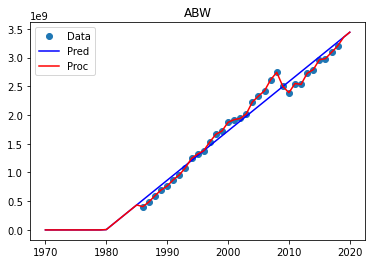

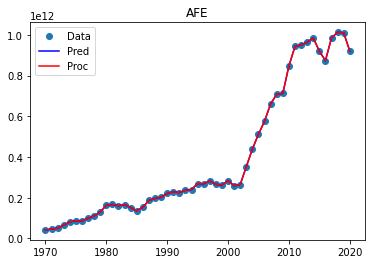

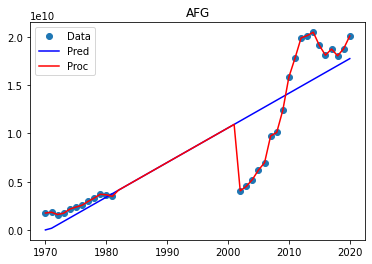

In [9]:
'''gdp_list=processed_gdp.ISO.unique()
for elem in gdp_list:
    dddd = gdp_data.loc[gdp_data.ISO==elem]
    pred = temp.loc[temp.ISO==elem]
    proc = processed_gdp.loc[processed_gdp.ISO==elem]
    X=dddd.year
    Y=dddd.GDP
    fig, ax = plt.subplots()
    ax.plot(X, Y, "o", label="Data")
    ax.plot(pred.year, pred.GDP , "b-", label="Pred")
    ax.plot(proc.year, proc.GDP , "r-", label="Proc")
    ax.legend(loc="best")
    plt.title(elem)
    plt.show()'''

gdp_list=processed_gdp.ISO.unique()
num = 0
for elem in gdp_list:
    dddd = gdp_data.loc[gdp_data.ISO==elem]
    pred = temp.loc[temp.ISO==elem]
    proc = processed_gdp.loc[processed_gdp.ISO==elem]
    X=dddd.year
    Y=dddd.GDP
    fig, ax = plt.subplots()
    ax.plot(X, Y, "o", label="Data")
    ax.plot(pred.year, pred.GDP , "b-", label="Pred")
    ax.plot(proc.year, proc.GDP , "r-", label="Proc")
    ax.legend(loc="best")
    plt.title(elem)
    plt.show()
    num +=1
    if num == 3:
        break


In [10]:
gdp_data = processed_gdp
gdp_data

,year,ISO,GDP
0,1970,ABW,0.000000e+00
1,1971,ABW,0.000000e+00
2,1972,ABW,0.000000e+00
3,1973,ABW,0.000000e+00
4,1974,ABW,0.000000e+00
...,...,...,...
13561,2016,ZWE,2.054868e+10
13562,2017,ZWE,1.758490e+10
13563,2018,ZWE,1.811550e+10
13564,2019,ZWE,1.928430e+10


###### 데이터 간 나라 불균형 전처리

In [11]:
codes = pop_data.ISO.unique()
years = [i for i in range(1970, 2020+1)]

A = set(ghg_data.ISO.unique())
B = set(pop_data.ISO.unique())
C = set(gdp_data.ISO.unique())
D = A-B
E = A-C
E

{'AIA',
 'AIR',
 'ANT',
 'ATF',
 'BVT',
 'CCK',
 'COK',
 'CXR',
 'ESH',
 'FLK',
 'GIB',
 'GLP',
 'GUF',
 'MSR',
 'MTQ',
 'MYT',
 'NFK',
 'NIU',
 'PCN',
 'PRK',
 'REU',
 'SCG',
 'SEA',
 'SHN',
 'SPM',
 'TKL',
 'TWN',
 'UMI',
 'VGB',
 'WLF'}

In [12]:
missing_list = {}
for elem in E:
    missing_list[elem] = ghg_data.loc[ghg_data.ISO == elem].country.values[0]
missing_list

{'CXR': 'Christmas Island',
 'NIU': 'Niue',
 'GLP': 'Guadeloupe',
 'REU': 'R?union',
 'FLK': 'Falkland Islands (Malvinas)',
 'PRK': "Korea, Dem. People's Rep.",
 'GUF': 'French Guiana',
 'SEA': 'Int. Shipping',
 'ANT': 'Netherlands Antilles',
 'MSR': 'Montserrat',
 'UMI': 'United States Minor Outlying Islands',
 'SHN': 'Saint Helena, Ascension and Tristan da Cunha',
 'ATF': 'French Southern Territories',
 'AIR': 'Int. Aviation',
 'GIB': 'Gibraltar',
 'TKL': 'Tokelau',
 'CCK': 'Cocos (Keeling) Islands',
 'BVT': 'Bouvet Island',
 'NFK': 'Norfolk Island',
 'COK': 'Cook Islands',
 'VGB': 'British Virgin Islands',
 'AIA': 'Anguilla',
 'MYT': 'Mayotte',
 'WLF': 'Wallis and Futuna',
 'ESH': 'Western Sahara',
 'PCN': 'Pitcairn',
 'SCG': 'Serbia and Montenegro',
 'TWN': 'Taiwan, China',
 'MTQ': 'Martinique',
 'SPM': 'Saint Pierre and Miquelon'}

###### 값이 작아서 제거 가능한 나라들: Pitcairn, Bouvet Island, Norfolk Island, UMI, Christmas Island, Cocos Island
###### 인구가 없는 ISO 표기: AIR(비행기) SEA(국제운송)
###### 나라가 분할되거나 하나의 나라 안으로 통합된 경우: ATF(프랑스 남부 지역), SCG(세르비아 몬테네그로)

In [13]:
#전부 제거
for elem in E:
    _idx = ghg_data.loc[ghg_data.ISO == elem].index
    ghg_data = ghg_data.drop(_idx)

In [14]:
'''A = ghg_data.ISO.unique()
B = ghg_data.region_ar6_dev.unique()
for country in ghg_data.ISO.unique():
    for year in range(1970, 2021):
        
    dev = ghg_data.loc[ghg_data.ISO==country].values[0][2]
    if dev == "developing":
        print(country, "developing")
    elif dev == "developed":
        print(country, "developed")
    else:
        print(country, "ldc")
        '''

'A = ghg_data.ISO.unique()\nB = ghg_data.region_ar6_dev.unique()\nfor country in ghg_data.ISO.unique():\n    for year in range(1970, 2021):\n        \n    dev = ghg_data.loc[ghg_data.ISO==country].values[0][2]\n    if dev == "developing":\n        print(country, "developing")\n    elif dev == "developed":\n        print(country, "developed")\n    else:\n        print(country, "ldc")\n        '

In [15]:
pop_temp= []
for year in years:
    for country in codes:
        pop_temp.append(pop_data.loc[(pop_data.ISO == country)&(pop_data.year == year), ["population", "year", "ISO"]])


In [16]:
result = pd.concat(pop_temp, axis=0)
ghg_data = pd.merge(ghg_data, result, on=["year", "ISO"], how="left")
ghg_data = pd.merge(ghg_data, gdp_data, on=["year", "ISO"], how="left")
ghg_data = ghg_data.fillna(method="pad")
#ghg_data = ghg_data.astype({"population": np.int64})
ghg_data

,ISO,country,region_ar6_dev,year,subsector_title,CO2,CH4,N2O,Fgas,GHG,population,GDP
0,ABW,Aruba,developing,1970,Residential,5.452099e+02,4.345413,1.310954,0.0,5.508663e+02,59070,0.000000e+00
1,ABW,Aruba,developing,1970,Electricity & heat,3.091397e+04,11.220446,36.717278,0.0,3.096191e+04,59070,0.000000e+00
2,ABW,Aruba,developing,1970,Oil and gas fugitive emissions,6.324320e-03,1142.233938,0.000000,0.0,1.142240e+03,59070,0.000000e+00
3,ABW,Aruba,developing,1970,Other (energy systems),3.173774e+04,133.755885,312.137205,0.0,3.218363e+04,59070,0.000000e+00
4,ABW,Aruba,developing,1970,Chemicals,1.455350e+03,0.000000,0.177366,0.0,1.455528e+03,59070,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
183123,ZWE,Zimbabwe,developing,2020,Metals,7.720092e+05,0.000000,0.000000,0.0,7.720092e+05,14862927,1.805120e+10
183124,ZWE,Zimbabwe,developing,2020,Other (industry),9.523549e+05,0.000000,0.000000,0.0,9.523549e+05,14862927,1.805120e+10
183125,ZWE,Zimbabwe,developing,2020,Other (transport),3.099450e+05,0.000000,0.000000,0.0,3.099450e+05,14862927,1.805120e+10
183126,ZWE,Zimbabwe,developing,2020,Rail,1.491236e+05,0.000000,0.000000,0.0,1.491236e+05,14862927,1.805120e+10


In [17]:
#train_x = pd.DataFrame(ghg_data[["year", "country", "population","region_ar6_dev", "subsector_title"]])
dff= pd.DataFrame(ghg_data[["ISO", "year", "GHG", "GDP","population","region_ar6_dev", "subsector_title"]])

In [18]:
dff

,ISO,year,GHG,GDP,population,region_ar6_dev,subsector_title
0,ABW,1970,5.508663e+02,0.000000e+00,59070,developing,Residential
1,ABW,1970,3.096191e+04,0.000000e+00,59070,developing,Electricity & heat
2,ABW,1970,1.142240e+03,0.000000e+00,59070,developing,Oil and gas fugitive emissions
3,ABW,1970,3.218363e+04,0.000000e+00,59070,developing,Other (energy systems)
4,ABW,1970,1.455528e+03,0.000000e+00,59070,developing,Chemicals
...,...,...,...,...,...,...,...
183123,ZWE,2020,7.720092e+05,1.805120e+10,14862927,developing,Metals
183124,ZWE,2020,9.523549e+05,1.805120e+10,14862927,developing,Other (industry)
183125,ZWE,2020,3.099450e+05,1.805120e+10,14862927,developing,Other (transport)
183126,ZWE,2020,1.491236e+05,1.805120e+10,14862927,developing,Rail


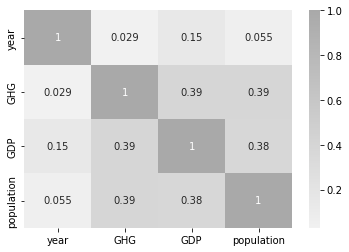

In [19]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(dff.corr(), annot=True, cmap=cmap)
plt.show()

In [20]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

mm = MinMaxScaler()
ss = StandardScaler()
rs = RobustScaler()
cols = ["GHG", "GDP","population"]
dff[cols] = rs.fit_transform(dff[cols])

<AxesSubplot:xlabel='region_ar6_dev', ylabel='GHG'>

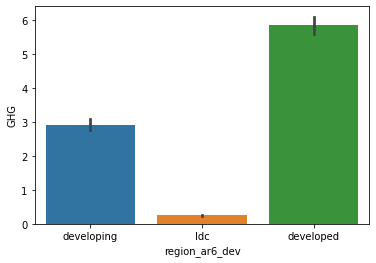

In [21]:
sns.barplot(x = dff['region_ar6_dev'], y = dff['GHG'])

<AxesSubplot:xlabel='GHG', ylabel='subsector_title'>

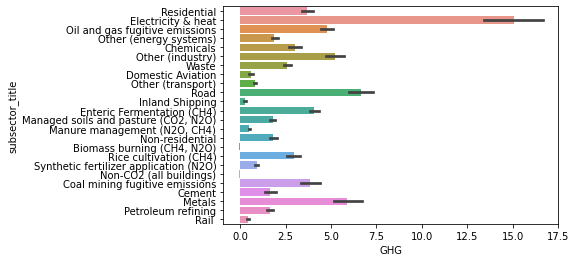

In [22]:
sns.barplot(y = dff['subsector_title'], x = dff['GHG'])

<AxesSubplot:xlabel='GHG', ylabel='ISO'>

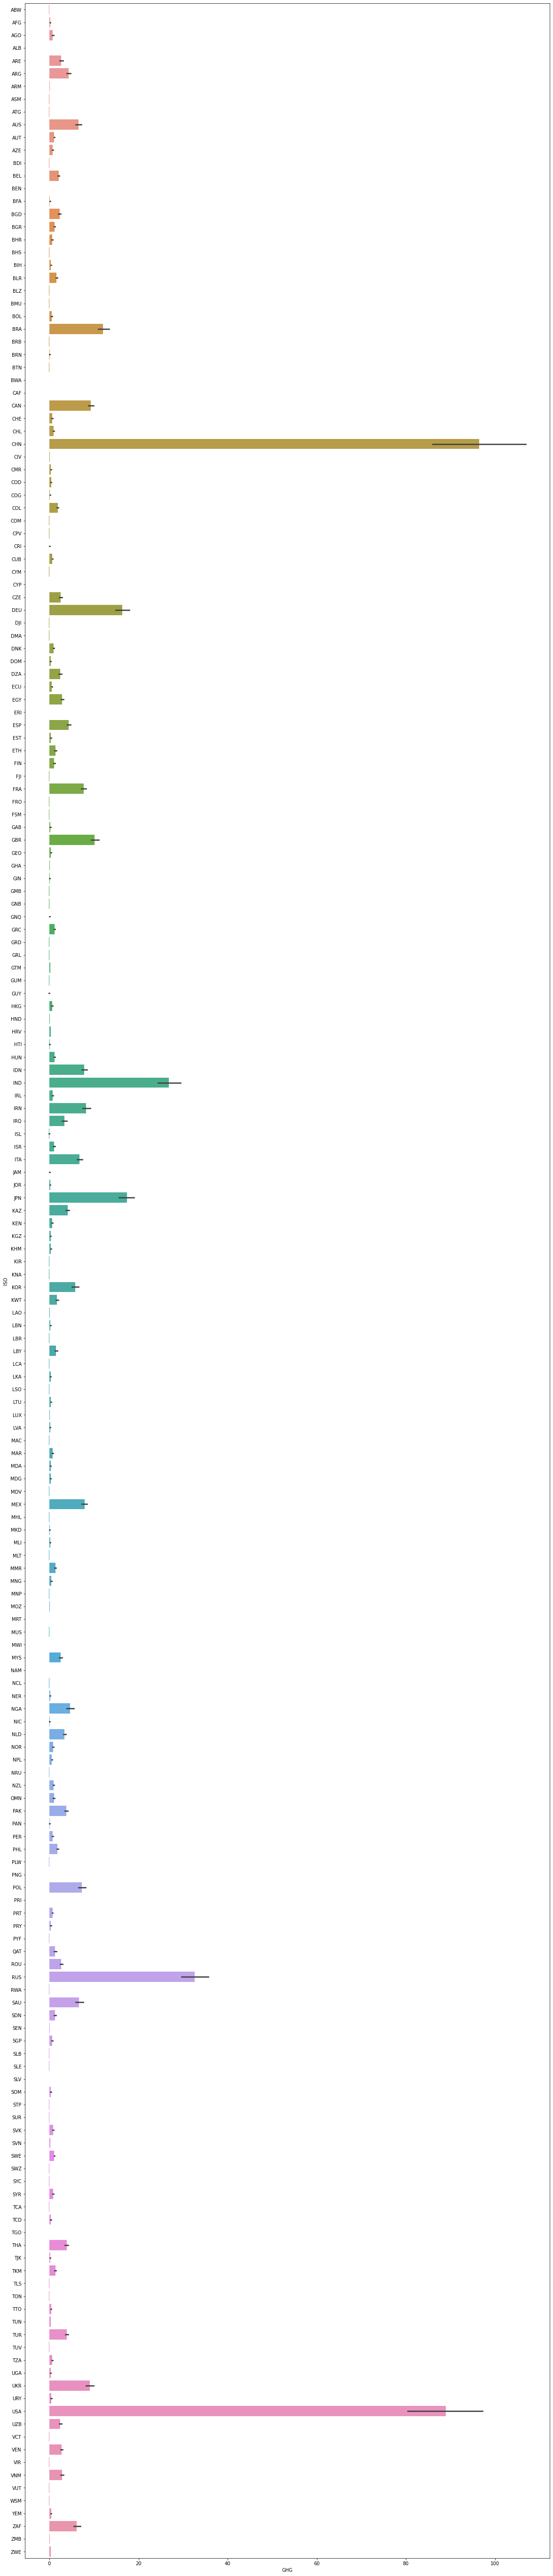

In [23]:
plt.figure(figsize=(20, 100))   
sns.barplot(y = dff['ISO'], x = dff['GHG'])

<AxesSubplot:xlabel='year', ylabel='GHG'>

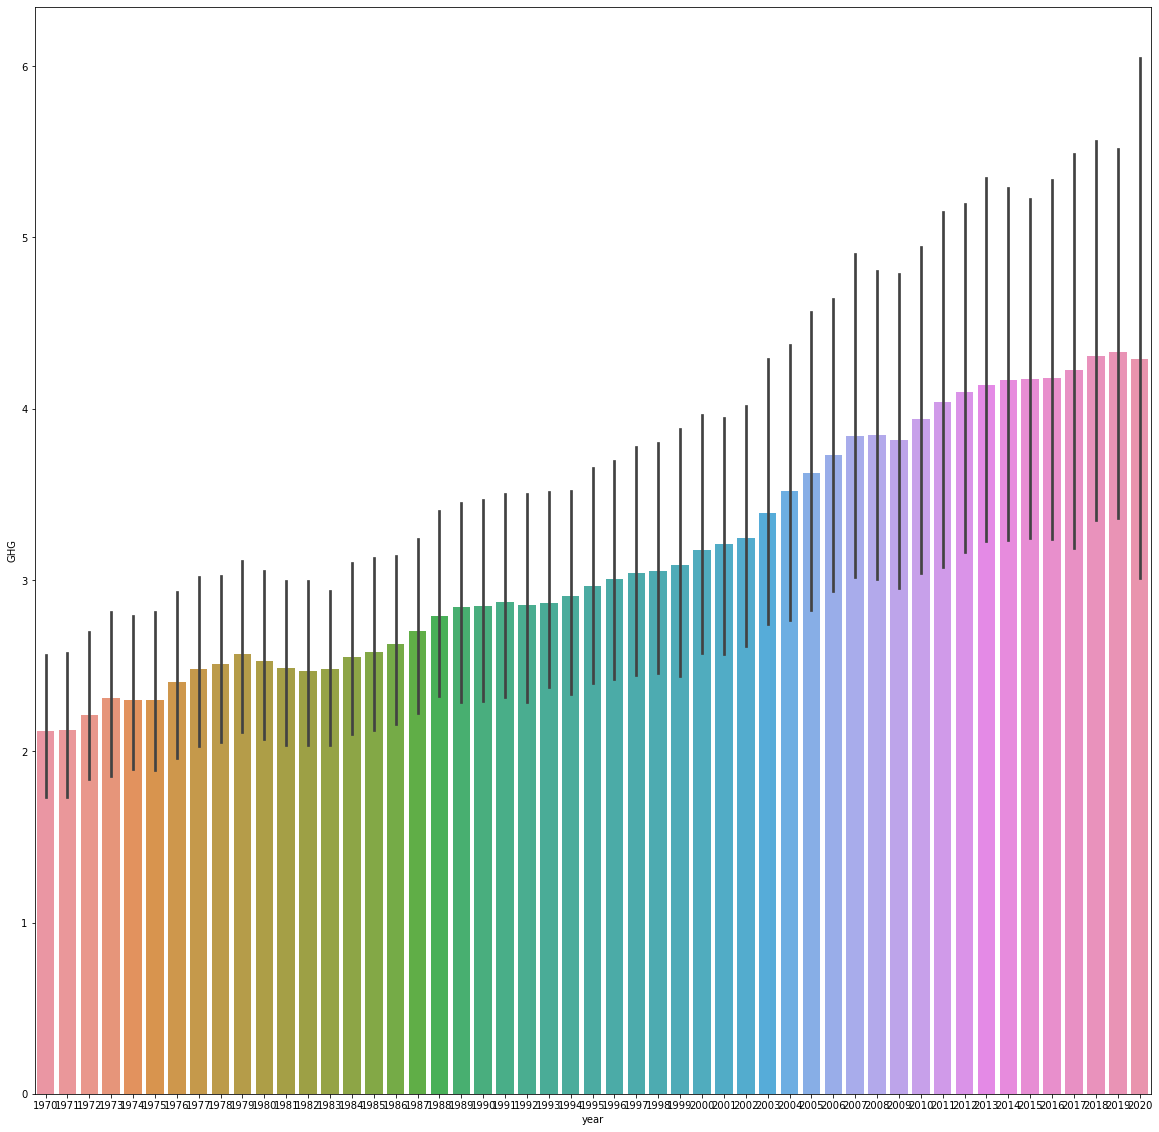

In [24]:
plt.figure(figsize=(20, 20))   
sns.barplot(x = dff['year'], y = dff['GHG'])

In [25]:
dff

,ISO,year,GHG,GDP,population,region_ar6_dev,subsector_title
0,ABW,1970,-0.138699,-0.146873,-0.340163,developing,Residential
1,ABW,1970,-0.128569,-0.146873,-0.340163,developing,Electricity & heat
2,ABW,1970,-0.138502,-0.146873,-0.340163,developing,Oil and gas fugitive emissions
3,ABW,1970,-0.128162,-0.146873,-0.340163,developing,Other (energy systems)
4,ABW,1970,-0.138398,-0.146873,-0.340163,developing,Chemicals
...,...,...,...,...,...,...,...
183123,ZWE,2020,0.118288,0.102228,0.382589,developing,Metals
183124,ZWE,2020,0.178364,0.102228,0.382589,developing,Other (industry)
183125,ZWE,2020,-0.035634,0.102228,0.382589,developing,Other (transport)
183126,ZWE,2020,-0.089207,0.102228,0.382589,developing,Rail


###### 모든 변수를 포함한 선형모델 피팅
ghg(섹터별 온실가스량) = wGDP + wPopulation + w(Sector: 카테고리) + w(Develop: 카테고리) + w(ISO: 카테고리)

In [26]:
model = smf.ols("GHG ~ 0 + GDP + population + region_ar6_dev + subsector_title + ISO" , data=dff)
results_fu = model.fit()
results_fu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GHG   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     313.3
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:59:02   Log-Likelihood:            -8.0559e+05
No. Observations:              183128   AIC:                         1.612e+06
Df Residuals:                  182903   BIC:                         1.614e+06
Df Model:                         224                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
region_ar6_dev[developed]                                    -0.1818      0.218     -0.836      0.403      -0.608       0.245
region_ar6_dev[developing]                                   -3.0259      0.811     -3.730      0.000      -4.616      -1.436
region_ar6_dev[ldc]                                          -3.0632      0.217    -14.093      0.000      -3.489      -2.637
subsector_title[T.Cement]                                     0.7429      0.307      2.421      0.015       0.142       1.344
subsector_title[T.Chemicals]                                  3.1132      0.283     11.002      0.000       2.559       3.668
subsector_title[T.Coal mining fugitive emissions]             0.1198      0.382      0.313      0.754      -0.629       0.869
subsector_title[T.Domestic Aviation]                         -0.2052      0.320     -0.642      0.521      -0.832       0.421
subsector_title[T.Electricity & heat]                        15.0756      0.286     52.755      0.000      14.516      15.636
subsector_title[T.Enteric Fermentation (CH4)]                 4.1586      0.285     14.572      0.000       3.599       4.718
subsector_title[T.Inland Shipping]                           -1.1098      0.341     -3.258      0.001      -1.777      -0.442
subsector_title[T.Managed soils and pasture (CO2, N2O)]       1.8395      0.284      6.480      0.000       1.283       2.396
subsector_title[T.Manure management (N2O, CH4)]               0.5993      0.285      2.103      0.035       0.041       1.158
subsector_title[T.Metals]                                     3.7328      0.339     11.012      0.000       3.068       4.397
subsector_title[T.Non-CO2 (all buildings)]                   -0.4926      0.327     -1.507      0.132      -1.133       0.148
subsector_title[T.Non-residential]                            0.8009      0.315      2.542      0.011       0.183       1.418
subsector_title[T.Oil and gas fugitive emissions]             3.5232      0.316     11.134      0.000       2.903       4.143
subsector_title[T.Other (energy systems)]                     1.9181      0.285      6.727      0.000       1.359       2.477
subsector_title[T.Other (industry)]                           5.2348      0.285     18.348      0.000       4.676       5.794
subsector_title[T.Other (transport)]                          0.2949      0.304      0.971      0.332      -0.300       0.890
subsector_title[T.Petroleum refining]                        -0.7136      0.343     -2.083      0.037      -1.385      -0.042
subsector_title[T.Rail ]                                     -2.3228      0.365     -6.360      0.000      -3.039      -1.607
subsector_title[T.Residential]                             

###### 나라별 피팅
ghg(섹터별 온실가스량) = wGDP + wPopulation + w(Sector: 카테고리)

한 나라의 산업군의 변화가 적고 일정할 경우는 모델 적합성이 높다.
(ex. 일본은 산업의 형태가 거의 변화하지 않음)

1970년 ~ 2010년동안 주력 산업군의 변화가 있었던 경우 모델 적합성이 낮다.
(ex. 경제가 급격하게 성장한 한국, 대만, 중국 등등)

따라서 선진국, 후진국의 경우 1970년 부터 2010년까지의 선형모델이 적합
1970년 부터 2010년까지 급격한 변화가 있던 개발도상국의 경우에는 선형모델이 적합하지 않음


In [27]:

train_years = [i for i in range(1970, 2010+1)]
valid_years = [i for i in range(2011, 2020+1)]

for ISO in ["BGD"]:
    train_XY = dff.loc[(dff.ISO==ISO)&(dff["year"].isin(train_years))]
    valid_XY = dff.loc[(dff.ISO==ISO)&(dff["year"].isin(valid_years))]
    model = smf.ols("GHG ~ 0 + GDP + population + subsector_title" , data=train_XY)
    results_fu = model.fit()
results_fu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GHG   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1171.
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:59:02   Log-Likelihood:                -1146.8
No. Observations:                 908   AIC:                             2344.
Df Residuals:                     883   BIC:                             2464.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
subsector_title[Biomass burning (CH4, N2O)]                -0.1671      0.257     -0.651      0.515      -0.671       0.337
subsector_title[Cement]                                     0.0286      0.257      0.111      0.911      -0.475       0.533
subsector_title[Chemicals]                                  0.2984      0.257      1.162      0.246      -0.206       0.802
subsector_title[Coal mining fugitive emissions]            -0.9341      0.412     -2.265      0.024      -1.743      -0.125
subsector_title[Electricity & heat]                         1.8689      0.257      7.277      0.000       1.365       2.373
subsector_title[Enteric Fermentation (CH4)]                 6.4387      0.257     25.069      0.000       5.935       6.943
subsector_title[Inland Shipping]                           -0.1582      0.257     -0.616      0.538      -0.662       0.346
subsector_title[Managed soils and pasture (CO2, N2O)]       3.0293      0.257     11.795      0.000       2.525       3.533
subsector_title[Manure management (N2O, CH4)]               0.3515      0.257      1.369      0.171      -0.153       0.856
subsector_title[Metals]                                    -0.3035      0.257     -1.182      0.238      -0.808       0.201
subsector_title[Non-CO2 (all buildings)]                   -0.3038      0.257     -1.183      0.237      -0.808       0.200
subsector_title[Non-residential]                           -0.2584      0.257     -1.006      0.315      -0.762       0.246
subsector_title[Oil and gas fugitive emissions]             0.5179      0.257      2.016      0.044       0.014       1.022
subsector_title[Other (energy systems)]                    -0.1427      0.257     -0.556      0.579      -0.647       0.361
subsector_title[Other (industry)]                           0.7379      0.257      2.873      0.004       0.234       1.242
subsector_title[Other (transport)]                          0.0637      0.257      0.248      0.804      -0.440       0.568
subsector_title[Petroleum refining]                        -0.2575      0.257     -1.003      0.316      -0.762       0.247
subsector_title[Rail ]                                     -0.2153      0.257     -0.838      0.402      -0.719       0.289
subsector_title[Residential]                                1.7615      0.257      6.858      0.000       1.257       2.266
subsector_title[Rice cultivation (CH4)]                    22.5765      0.257     87.902      0.000      22.072      23.081
subsector_title[Road]                                       0.2532      0.257      0.986      0.324      -0.251       0.757
subsector_title[Synthetic fertilizer application (N2O)]     0.6108      0.257      2.378      0.018       0

In [28]:


#카테고리 변수 더미화 코드
dff = pd.merge(dff, pd.get_dummies(dff['region_ar6_dev']), left_index = True, right_index = True)
dff.drop("region_ar6_dev", axis=1, inplace=True)
dff = pd.merge(dff, pd.get_dummies(dff['subsector_title']), left_index = True, right_index = True)
dff.drop("subsector_title", axis=1, inplace=True)


###### 나라별, 섹터별 피팅

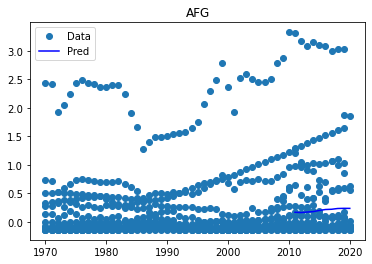

/Users/user/opt/anaconda3/envs/Joljak/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    GHG   R-squared (uncentered):                   0.058
Model:                            OLS   Adj. R-squared (uncentered):              0.056
Method:                 Least Squares   F-statistic:                              25.92
Date:                Fri, 01 Jul 2022   Prob (F-statistic):                    1.19e-11
Time:                        18:59:02   Log-Likelihood:                         -666.56
No. Observations:                 841   AIC:                                      1337.
Df Residuals:                     839   BIC:                                      1347.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
GDP                 -0.5180      0.275     -1.883      0.060      -1.058       0.022
population           0.1964      0.038      5.192      0.000       0.122       0.271
developing:Waste          0          0        nan        nan           0           0
==============================================================================
Omnibus:                      575.197   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5314.040
Skew:                           3.171   Prob(JB):                         0.00
Kurtosis:                      13.556   Cond. No.                          inf
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:

train_years = [i for i in range(1970, 2010+1)]
valid_years = [i for i in range(2011, 2020+1)]
whole_years = [i for i in range(1970, 2020+1)]
vv = pd.DataFrame(valid_years)
toof = pd.DataFrame(train_years)
vv.columns = ["year"]
for ISO in ["AFG"]:
    train_XY = dff.loc[(dff.ISO==ISO)&(dff["year"].isin(train_years))]
    valid_XY = dff.loc[(dff.ISO==ISO)&(dff["year"].isin(valid_years))]
    model = smf.ols("GHG ~ 0 + GDP + population + developing:Waste" , data=train_XY)
    results_fu = model.fit()
    valid_X = valid_XY.drop("GHG", axis=1)
    valid_Y = valid_XY["GHG"]
    valid_X = sm.add_constant(valid_X)
    pred = results_fu.predict(valid_X)
    pred = pd.DataFrame(pred.unique())
    pred.columns=["GHG"]
    pred = pd.merge(vv, pred, left_index=True, right_index = True)
    fig, ax = plt.subplots()
    ax.plot(dff.loc[dff.ISO==ISO].year, dff.loc[dff.ISO==ISO].GHG, "o", label="Data")
    ax.plot(pred.year, pred.GHG, "b-", label="Pred")
    ax.legend(loc="best")
    plt.title(ISO)
    plt.show()
    

results_fu.summary()

In [30]:
indexlist = []
for attributeIndex in range (0, len(results_fu.pvalues)):
    if results_fu.pvalues[attributeIndex]<0.005:
        indexlist.append(attributeIndex)
print(indexlist)

[1]


In [31]:
dff.region_ar6_dev.unique()

AttributeError: 'DataFrame' object has no attribute 'region_ar6_dev'

In [ ]:
dff.subsector_title.unique()
dff.ISO.unique()